In [81]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [82]:
def get_line_params(xvals, yvals):
    # ax + by + c = 0
    dx = np.amax(xvals) - np.amin(xvals)
    dy = np.amax(yvals) - np.amin(yvals)
    
    if dx != 0 and dy != 0: # Regular line
        a = - dy / dx
        b = 1
        c = (yvals[0] + a * xvals[0])
        return a, b, c
    
    elif dx == 0:  # Vertical line x = - c / a
        a = 1
        b = 0
        c = -xvals[0]
        return a, b, c
        
    elif dy == 0:   # Horizontal line y = -c / b
        a = 0
        b = 1
        c = -yvals[0]
        return a, b, c

    
    
def rotate_point(px, py, cx, cy, angle):
    s = np.sin(angle)
    c = np.cos(angle)
    px -= cx
    py -= cy
    xnew = px * c - py * s
    ynew = px * s + py * c
    px = xnew + cx
    py = ynew + cy
    return px, py


def point_in_rectangle(px, py, rect):
    rx_min, rx_max = min(rect[:, 0]), max(rect[:, 0])
    ry_min, ry_max = min(rect[:, 1]), max(rect[:, 1])
    return rx_min < px < rx_max and ry_min < py < ry_max


def check_overlap(x_length, y_length, angle1, angle2, point):
    # Define the vertices of the base rectangle (centered at origin, for example)
    
    length = min((x_length, y_length))
    width = max((x_length, y_length))
    
    rect1 = np.array([[-length, -width], [length, -width], [length, width], [-length, width]])

    # Define the center
    center = (0, 0)
    
    # Apply rotation to the vertices of the second rectangle
    rect2 = np.array([rotate_point(x, y, *center, angle2) for x, y in rect1])
    rect3 = np.array([rotate_point(x, y, *center, angle1) for x, y in rect1])

    rot_point = rotate_point(point[0], point[1], *center, angle2)
    
    # Check if the point is within both rectangles
    inside_rect2 = point_in_rectangle(point[0], point[1], rect3)
    inside_rect3 = point_in_rectangle(rot_point[0], rot_point[1], rect1)

    # Determine if the point is in the overlapping area
    in_overlap = inside_rect2 and inside_rect3
    
    return in_overlap


def rotate_coordinates(coords, theta):
    """
    Rotate a set of 2D coordinates by theta radians.

    Args:
        coords: A NumPy array of shape (n, 2) where n is the number of coordinates.
        theta: The rotation angle in radians.

    Returns:
        A NumPy array of the rotated coordinates.
    """
    # Define the rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    # Apply the rotation matrix to the coordinates
    rotated_coords = np.dot(coords, rotation_matrix)
    return rotated_coords


def point_to_line_distance(a, b, c, x0, y0):
    return abs(a * x0 + b * y0 + c) / np.sqrt(a**2 + b**2)


def compute_intercept(a1, b1,c1, a2, b2, c2):
    x_intercept = (b1*c2 - b2*c1) / (a1*b2 - a2*b1)
    y_intercept = (c1*a2 - c2*a1) / (a1*b2 - a2*b1)
    
    return x_intercept, y_intercept


In [83]:
class SCTModule:
    
    def __init__(self, width=63.56, length=128.05, nstrips=768, stereo_angle=0.04, rotation=0):
        
        self.nstrips = nstrips
        self.rotation = rotation
        self.stereo_angle = stereo_angle
        self.width = width
        self.length = length
        # vertical strips
        # if abs(rotation) < np.pi/2:
        self.x_length = width
        self.y_length = length

        self._hits_in_area = None
        # horizontal strips
        # else:
        #     self.x_length = length
        #     self.y_length = width
        #     print(self.x_length, self.y_length)

        
        self._angle_top = rotation
        self._angle_bottom = stereo_angle + rotation
        
        self._x = np.linspace(-self.x_length/2, self.x_length/2, nstrips+1 )
        self._y = np.linspace(-self.y_length/2, self.y_length/2, nstrips+1)
            
        _coords = []
        # if abs(rotation) < np.pi/2:
        for xx in self._x:
            _coords.append(np.array([[xx, self.y_length/2], [xx, -self.y_length/2]]))
        # else:
        #     for yy in self._y:
        #         _coords.append(np.array([[self.x_length/2, yy], [-self.x_length/2, yy]]))                


        self._coords_top = rotate_coordinates(_coords, self._angle_top)
        self._coords_bottom = rotate_coordinates(_coords, self._angle_bottom)


        self._top_line_params = [get_line_params(self._coords_top[i][:,0], self._coords_top[i][:,1]) for i in range(0, len(self._coords_top))]
        self._bottom_line_params = [get_line_params(self._coords_bottom[i][:,0], self._coords_bottom[i][:,1]) for i in range(0, len(self._coords_bottom))]
        
    def draw_strips(self, ax):
            
        for i in range(len(self._coords_top)):
            ax.plot(self._coords_top[i][:,0], self._coords_top[i][:,1], color='black', linewidth=0.1, alpha=0.5, zorder=0, label='top strips')
        for i in range(len(self._coords_top)):
            ax.plot(self._coords_bottom[i][:,0], self._coords_bottom[i][:,1], color='orange', linewidth=0.1, alpha=0.5, zorder=0, label='bottom strips')

    
    def _get_activated_strips(self, params, hits_x, hits_y):
        hit_strips = []
        self._hits_in_area = 0
        for px, py in zip(hits_x, hits_y):
            distances = []
            
            if not check_overlap(self.x_length/2, self.y_length/2, self._angle_top, self._angle_bottom, (px, py)):
                continue
            
            self._hits_in_area += 1
            for a, b, c in params: 
                distance_to_line = point_to_line_distance(a, b, c, px, py)
                distances.append(distance_to_line)
            
            sorted_indices = np.argsort(distances)
            closest_lines = sorted_indices[:2]
            closest_lines = sorted(closest_lines)
            
            hit_strips += [[params[l] for l in closest_lines]]

        return hit_strips
    
    def get_space_points(self, hits_x, hits_y):
        
        hit_top_strips = self._get_activated_strips(self._top_line_params, hits_x, hits_y)
        hit_bottom_strips = self._get_activated_strips(self._bottom_line_params, hits_x, hits_y)
        
        x_intersection_points = []
        y_intersection_points = []
        
        space_points = set()
        space_points_x = []
        space_points_y = []

        for (top1, top2) in hit_top_strips:
            a11, b11, c11 = top1
            a12, b12, c12 = top2
            for (bottom1, bottom2) in hit_bottom_strips:
            
                a21, b21, c21 = bottom1
                a22, b22, c22 = bottom2
                    
                top1bottom1_intercept = compute_intercept(a11, b11, c11, a21, b21, c21)
                top1bottom2_intercept = compute_intercept(a11, b11, c11, a22, b22, c22)
                top2bottom1_intercept = compute_intercept(a12, b12, c12, a21, b21, c21)
                top2bottom2_intercept = compute_intercept(a12, b12, c12, a22, b22, c22)
                
                is_valid = True
                
                if check_overlap(self.x_length/2, self.y_length/2, self._angle_top, self._angle_bottom, (top1bottom1_intercept[0], top1bottom1_intercept[1])):
                    x_intersection_points.append(top1bottom1_intercept[0])
                    y_intersection_points.append(top1bottom1_intercept[1])
                else:
                    is_valid = False
                
                if check_overlap(self.x_length/2, self.y_length/2, self._angle_top, self._angle_bottom, (top1bottom2_intercept[0], top1bottom2_intercept[1])):
                    x_intersection_points.append(top1bottom2_intercept[0])
                    y_intersection_points.append(top1bottom2_intercept[1])
                else:
                    is_valid = False
                
                if check_overlap(self.x_length/2, self.y_length/2, self._angle_top, self._angle_bottom, (top2bottom1_intercept[0], top2bottom1_intercept[1])):
                    x_intersection_points.append(top2bottom1_intercept[0])
                    y_intersection_points.append(top2bottom1_intercept[1])
                else:
                    is_valid = False
                
                if check_overlap(self.x_length/2, self.y_length/2, self._angle_top, self._angle_bottom, (top2bottom2_intercept[0], top2bottom2_intercept[1])):
                    x_intersection_points.append(top2bottom2_intercept[0])
                    y_intersection_points.append(top2bottom2_intercept[1])
                else:
                    is_valid = False
                
                if is_valid:
                    sp_x = (top1bottom1_intercept[0] + top1bottom2_intercept[0] + top2bottom1_intercept[0] + top2bottom2_intercept[0]) / 4
                    sp_y = (top1bottom1_intercept[1] + top1bottom2_intercept[1] + top2bottom1_intercept[1] + top2bottom2_intercept[1]) / 4
                
                    # if sp_x not in space_points_x and sp_y not in space_points_y: 
                    space_points.add((sp_x, sp_y))

        space_points_x = [xy[0] for xy in space_points]
        space_points_y = [xy[1] for xy in space_points]
        
        return (space_points_x, space_points_y), (hit_top_strips, hit_bottom_strips), (x_intersection_points, y_intersection_points)

    
    def draw_hit_strips(self, ax, hit_strip_params, linewidth=1):
            
        for pair in hit_strip_params[0]:
            for (a, b, c) in pair:
                if abs(self.rotation) < np.pi/2:
                    ax.plot(0*self._x- c, self._y, color='lightblue', linewidth=linewidth, zorder=9, label="Selected top strips")
                else:
                    ax.plot(self._y, 0*self._x- c, color='lightblue', linewidth=linewidth, zorder=9, label="Selected top strips")
                
        for pair in hit_strip_params[1]:
            for (a, b, c) in pair:
                yp = []
                xp = []
                
                if abs(self.rotation) < np.pi/2:
                    for xx in np.linspace(-self.x_length/2, self.x_length/2, 5000):
                        p = (-a/b)*xx - c/b
                        if abs(p) <= self.length/2:
                            xp.append(xx)
                            yp.append(p)
                else:    
                    for yy in np.linspace(-self.x_length/2, self.y_length/2, 5000):
                        p = (b/a)*yy + c/a
                        if abs(p) <= self.length/2:
                            xp.append(p)
                            yp.append(yy)
                    
                ax.plot(xp, yp, color='blue', linewidth=linewidth, zorder=9, label="Selected bottom strips")
    
    
    def _sort_hits_from_ghosts(self, hits_x, hits_y, space_points_x, space_points_y):
        
        ghosts_x = deepcopy(space_points_x)
        ghosts_y = deepcopy(space_points_y)
        
        reco_hits_x = []
        reco_hits_y = []
        
        for i, (px, py) in enumerate(zip(hits_x, hits_y)):
            smallest_distance = 10e10
            
            if not check_overlap(self.x_length/2, self.y_length/2, self._angle_top, self._angle_bottom, (px, py)):
                continue
            
            best_idx = 0
            for j, (sx, sy) in enumerate(zip(ghosts_x, ghosts_y)):
                
                distance = np.sqrt((px - sx)**2 + (py - sy)**2)
                
                if distance < smallest_distance:
                    smallest_distance = distance
                    best_idx = j
            
            reco_hits_x.append(ghosts_x.pop(best_idx))
            reco_hits_y.append(ghosts_y.pop(best_idx))
        
        return (np.array(reco_hits_x), np.array(reco_hits_y)), (np.array(ghosts_x), np.array(ghosts_y))
    
    
    def draw_all(self, ax, hits_x, hits_y, draw_hits=True, draw_space_points=False, draw_strips=True, draw_hit_strips=True, draw_reco_hits=True, draw_ghosts=True):
        
        (space_points_x, space_points_y), hit_strip_params, _ = self.get_space_points(hits_x, hits_y)
        
        (reco_hits_x, reco_hits_y), (ghosts_x, ghosts_y) = self._sort_hits_from_ghosts(hits_x, hits_y, space_points_x, space_points_y)
        
        if draw_hit_strips:
            self.draw_hit_strips(ax, hit_strip_params, linewidth=0.1)
        
        if draw_strips:
            self.draw_strips(ax)
            
        if draw_hits:
            ax.scatter(hits_x, hits_y, color='magenta', s=0.1, zorder=9, label='True hits')
        
        if draw_space_points:
            ax.scatter(space_points_x, space_points_y, color='purple', s=0.1, zorder=9,  marker='v', label='Space points')
        
        if draw_ghosts:
            ax.scatter(ghosts_x, ghosts_y, color='red', marker='x', label='Ghosts hits', s=0.1, zorder=9)
        
        if draw_reco_hits:
            ax.scatter(reco_hits_x, reco_hits_y, color='lime', marker='.', label='Reco hits', s=0.1, zorder=9)
            
        # ax.set_xlim(10 * -self.width/2,  10 * self.width/2)
        # ax.set_ylim(10 * -self.length/2, 10 * self.length/2)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))
        ax.set_title(f"Number of space points is {len(space_points_x)}    Number of real hits was {self._hits_in_area}", loc='right', fontsize=8)
        ax.set_xlabel("x [mm]", loc='right')
        ax.set_ylabel("y [mm]", loc='top')
        
        return (reco_hits_x, reco_hits_y), (ghosts_x, ghosts_y)

In [84]:
module_1 = SCTModule()  # vertical strips
module_2 = SCTModule(rotation=np.pi/2) # horizontal strips

sct_width=63.56 
sct_length=128.05
np.random.seed(41)
n = 50
rpx = np.random.rand(n) * sct_width - sct_width/2
rpy = np.random.rand(n) * sct_width - sct_width/2

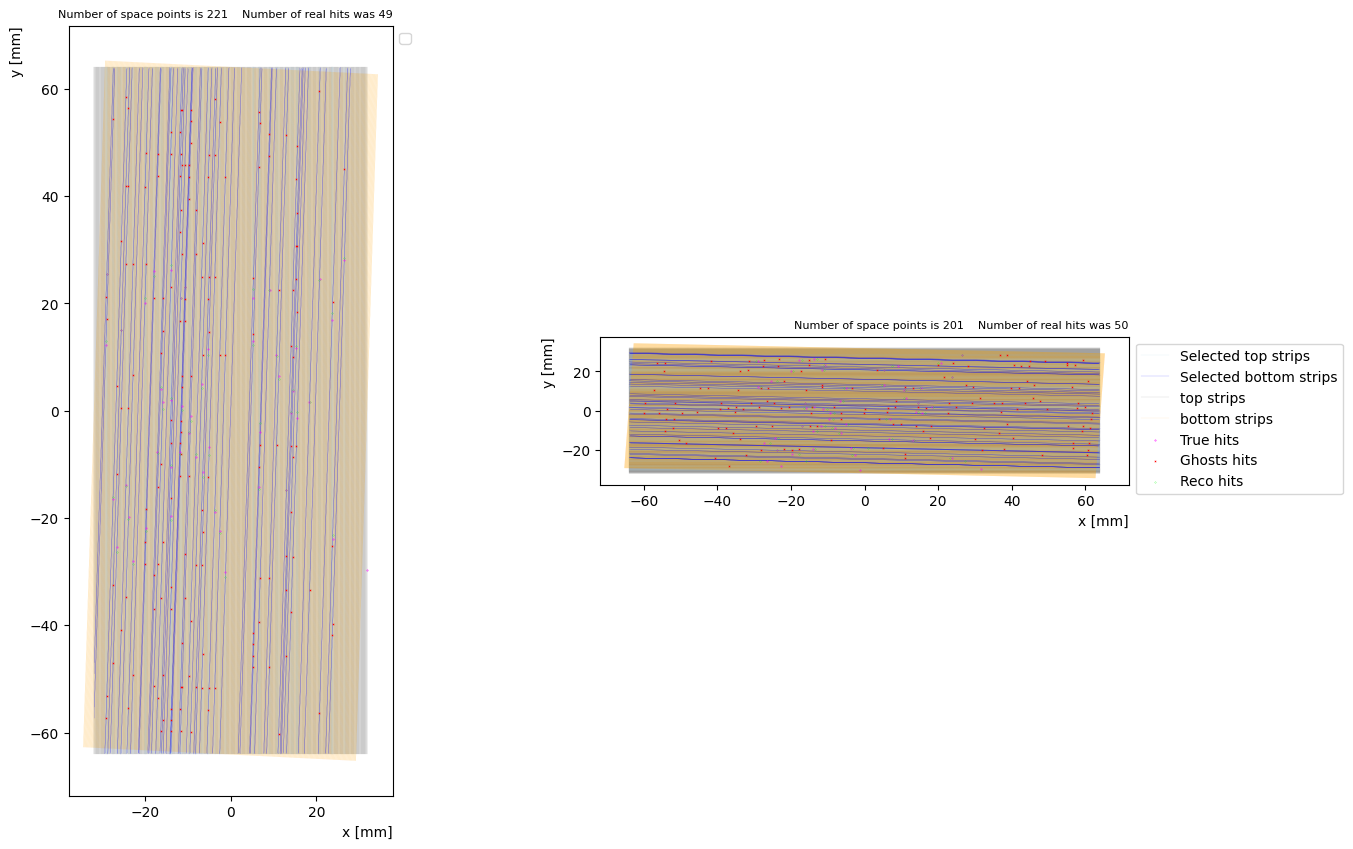

In [85]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
ax[0].set_aspect(7.5/6)
ax[1].set_aspect(4/7.5)
(reco_1x, reco_1y), (ghosts_1x, ghosts_1y) = module_1.draw_all(ax[0], rpx, rpy, draw_hits=True, draw_hit_strips=True)
(reco_2x, reco_2y), (ghosts_2x, ghosts_2y) = module_2.draw_all(ax[1], rpx, rpy, draw_hits=True, draw_hit_strips=True)
plt.savefig(f"{n}Hits-GhostsTest.pdf", bbox_inches='tight')

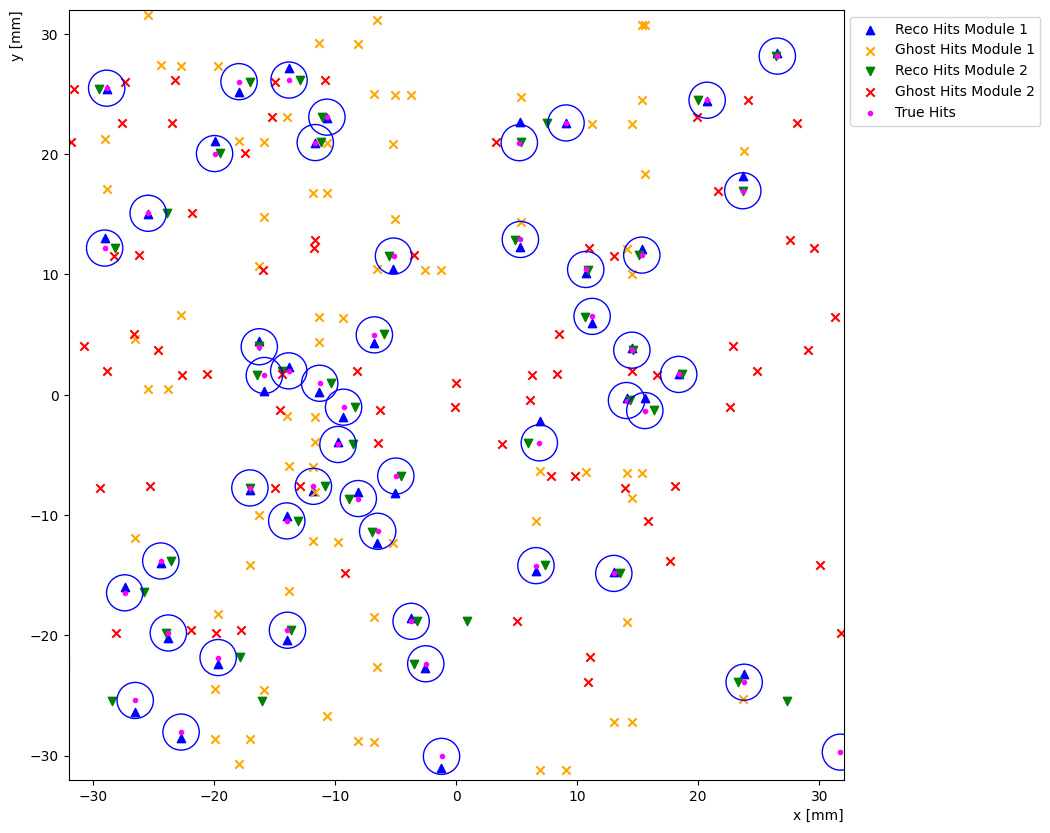

In [86]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(reco_1x, reco_1y, color='blue', marker='^', label='Reco Hits Module 1')
ax.scatter(ghosts_1x, ghosts_1y, color='orange', marker='x', label='Ghost Hits Module 1')

ax.scatter(reco_2x, reco_2y, color='green', marker='v', label='Reco Hits Module 2')
ax.scatter(ghosts_2x, ghosts_2y, color='red', marker='x', label='Ghost Hits Module 2')

ax.scatter(rpx, rpy, color='magenta', marker='.', label='True Hits')

for rx, ry in zip(rpx, rpy):
    circle = plt.Circle((rx, ry), 1.5, color='blue', fill=False)
    ax.add_artist(circle)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.set_xlim((-64/2, 64/2))
ax.set_ylim((-64/2, 64/2))
ax.set_xlabel("x [mm]", loc='right')
ax.set_ylabel("y [mm]", loc='top')

plt.savefig(f"{n}Hits-GhostsTest-Zoomed.pdf")

In [87]:
print("inside",  len(ghosts_2x[abs(ghosts_2x) < 63.56/2]))
print("outside", len(ghosts_2x[abs(ghosts_2x) > 63.56/2]))
print(len(ghosts_2x[abs(ghosts_2x) < 63.56/2]) / len(ghosts_2x[abs(ghosts_2x) > 63.56/2]))

inside 70
outside 81
0.8641975308641975


In [88]:
print("inside",  len(ghosts_1y[abs(ghosts_1y) < 63.56/2]))
print("outside", len(ghosts_1y[abs(ghosts_1y) > 63.56/2]))
print(len(ghosts_1y[abs(ghosts_1y) < 63.56 /2]) / len(ghosts_1y[abs(ghosts_1y) > 63.56/2]))

inside 79
outside 93
0.8494623655913979
